# K-Means Clustering from Scratch

K-Means is one of the most widely used **unsupervised learning algorithms**.  
Its goal is to partition a dataset into $K$ distinct clusters such that points within the same cluster are as similar as possible.

Unlike supervised learning methods, K-Means does **not** use labeled data.  
Instead, it discovers structure by minimizing distances between data points and cluster centroids.

In this notebook, we:
- Implement K-Means using our custom `rice_ml` package
- Apply it to a real dataset
- Analyze clustering behavior
- Visualize clusters using PCA
- Discuss strengths and limitations


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.processing.preprocessing import standardize
from rice_ml.unsupervised_learning.k_means_clustering import KMeans
from rice_ml.unsupervised_learning.pca import PCA

## Dataset Description

We use the Wine dataset from the UCI Machine Learning Repository.

The dataset contains physicochemical measurements of wines, such as:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Color intensity
- Hue

Although the dataset includes class labels, **they are not used** in this notebook since K-Means is an unsupervised algorithm.


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

columns = [
    "class", "alcohol", "malic_acid", "ash", "alcalinity",
    "magnesium", "total_phenols", "flavanoids",
    "nonflavanoid_phenols", "proanthocyanins",
    "color_intensity", "hue", "od280_od315", "proline"
]

df = pd.read_csv(url, header=None, names=columns)
df.head()

,class,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Separate Features for Unsupervised learning

In [3]:
X = df.drop(columns=["class"]).values
print("Feature matrix shape:", X.shape)

Feature matrix shape: (178, 13)


## Exploratory Data Analysis (EDA)

Before applying K-Means, we examine:
- Dataset shape
- Feature distributions
- Differences in feature scales

Understanding feature scales is especially important because K-Means relies on **Euclidean distance**.


### Target Distribution

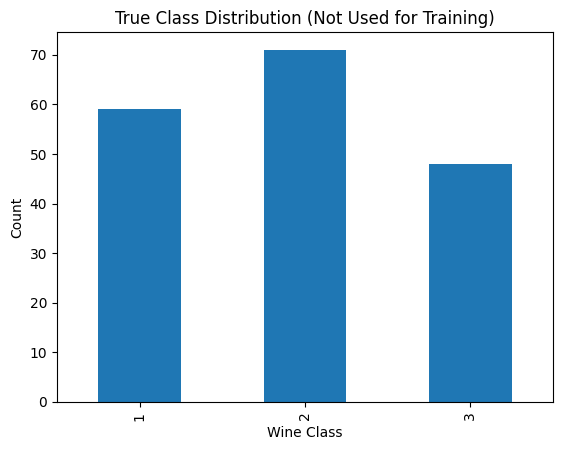

In [4]:
df["class"].value_counts().sort_index().plot(kind="bar")
plt.title("True Class Distribution (Not Used for Training)")
plt.xlabel("Wine Class")
plt.ylabel("Count")
plt.show()


### Feature Scale Comparison

K-Means clustering is highly sensitive to feature scale.  
If one feature has much larger values than others, it will dominate distance calculations.

The boxplot below shows that several features vary significantly in magnitude, motivating the need for feature standardization before clustering.


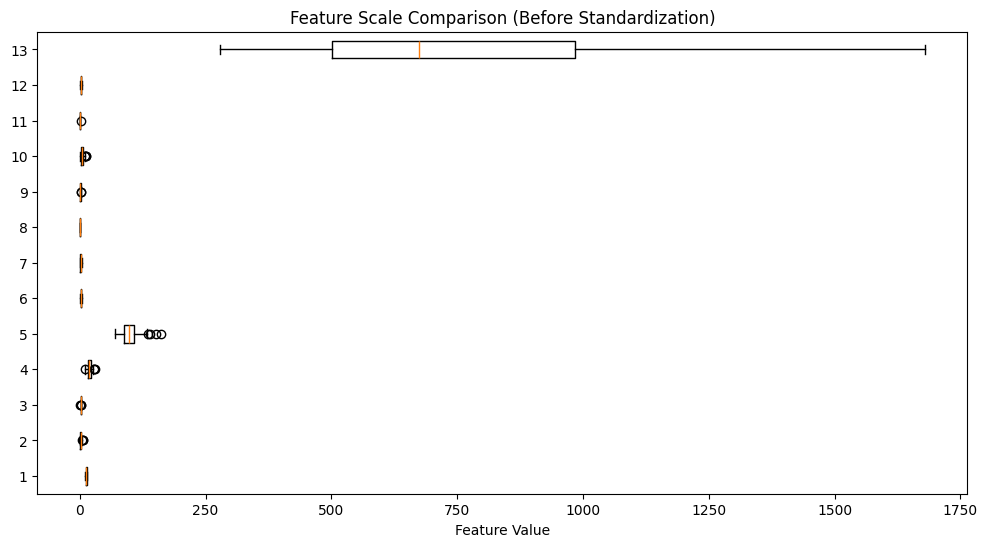

In [5]:
plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.show()


## Preprocessing

We standardize the feature matrix before clustering.

Standardization rescales each feature to have zero mean and unit variance:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

This ensures that all features contribute equally to distance computations and improves clustering stability.


In [6]:
X_std = standardize(X)

## K-Means Objective Function

K-Means attempts to minimize the total **within-cluster sum of squared distances**:

$$
\sum_{i=1}^{n} \left\| x_i - \mu_{c(i)} \right\|^2
$$

where:
- $x_i$ is a data point
- $\mu_{c(i)}$ is the centroid of the cluster assigned to $x_i$
- $c(i)$ denotes the cluster index for point $i$


## K-Means Algorithm

The K-Means algorithm proceeds iteratively:

1. Initialize $K$ cluster centroids
2. Assign each data point to the nearest centroid
3. Update each centroid as the mean of its assigned points
4. Repeat until convergence or until the maximum number of iterations is reached


## Model Training

In [7]:
kmeans = KMeans(
    n_clusters=3,
    max_iter=300,
    tol=1e-4,
    random_state=42
)

kmeans.fit(X_std)


## Inertia

Inertia measures how tightly points are clustered around centroids.

It is defined as:

$$
\text{Inertia} = \sum_{i=1}^{n} \left\| x_i - \mu_{c(i)} \right\|^2
$$

Lower inertia indicates more compact clusters, but inertia always decreases as $K$ increases.


### Clustering Results

- Labels indicate cluster membership
- Centroids represent cluster means
- Inertia measures within-cluster variance

In [8]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print("Cluster centers shape:", centers.shape)
print("Inertia:", kmeans.inertia_)


Cluster centers shape: (3, 13)
Inertia: 1277.9284888446423


## Elbow Method

The elbow method helps determine a reasonable number of clusters by plotting inertia as a function of $K$.

We look for a value of $K$ where the rate of decrease in inertia sharply slows, forming an "elbow" in the curve.

This point represents a good trade-off between model complexity and clustering quality.


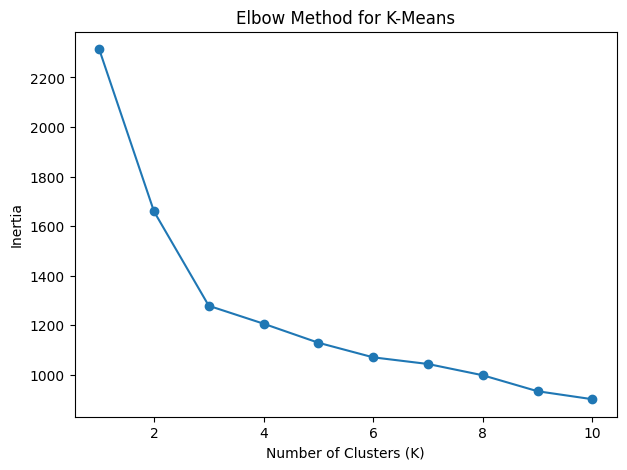

In [9]:
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_std)
    inertias.append(model.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(range(1, 11), inertias, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()


### Interpretation: 

The curve begins to flatten around 𝐾 = 3, suggesting diminishing returns beyond this point.

## PCA for Visualization

Because the dataset is high-dimensional, we use Principal Component Analysis (PCA) to project the data into two dimensions for visualization.

PCA finds orthogonal directions of maximum variance in the data.

Important note:
- PCA is used **only for visualization**
- Clustering is performed in the original standardized feature space


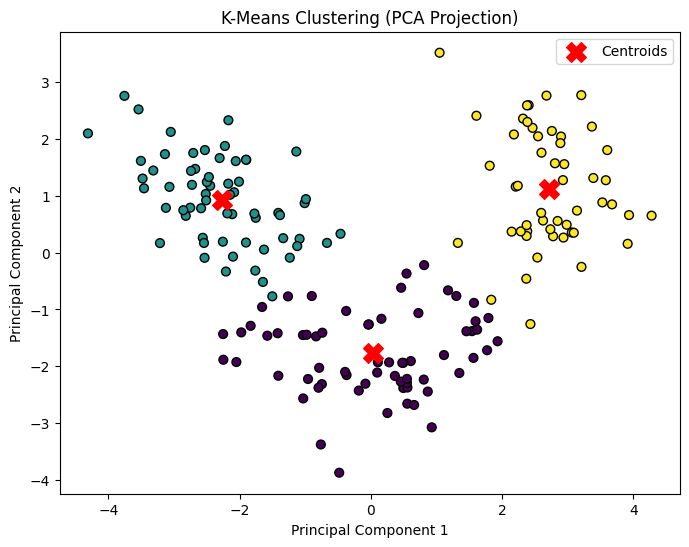

In [10]:
X_centered = X_std - X_std.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
X_pca = X_centered @ Vt[:2].T

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap="viridis",
    s=40,
    edgecolor="k"
)

plt.scatter(
    centers @ Vt[:2].T[:, 0],
    centers @ Vt[:2].T[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Centroids"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering (PCA Projection)")
plt.legend()
plt.show()


## Interpreting the Clusters

In the PCA projection:
- Points with the same color belong to the same cluster
- Red X markers indicate cluster centroids
- Clear separation suggests meaningful structure in the data

Because PCA is a linear projection, cluster boundaries may appear distorted, but assignments remain unchanged.


## Limitations of K-Means

While K-Means is simple and efficient, it has several limitations:

- Requires specifying $K$ in advance
- Assumes roughly spherical clusters
- Sensitive to initialization
- Sensitive to outliers
- Requires feature scaling


## Conclusion

K-Means clustering provides a simple yet powerful method for discovering structure in unlabeled data.

In this notebook, we demonstrated:
- A fully custom implementation of K-Means
- The importance of feature standardization
- How inertia and the elbow method guide cluster selection
- PCA-based visualization of high-dimensional clusters